# DQN for Highway Environment

This notebook implements and runs a DQN agent on the Highway environment with the configuration from config1.py.

In [1]:
# Install required packages
!pip install gymnasium
!pip install highway-env
!pip install torch
!pip install matplotlib

  Using cached highway_env-1.10.1-py3-none-any.whl.metadata (16 kB)
Using cached highway_env-1.10.1-py3-none-any.whl (104 kB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
   ---------------------------------------- 0.0/204.1 MB ? eta -:--:--
   ---------------------------------------- 0.3/204.1 MB ? eta -:--:--
   ---------------------------------------- 1.0/204.1 MB 2.6 MB/s eta 0:01:17
   ---------------------------------------- 1.3/204.1 MB 2.7 MB/s eta 0:01:16
   ---------------------------------------- 1.8/204.1 MB 2.5 MB/s eta 0:01:21
   ---------------------------------------- 2.4/204.1 MB 2.5 MB/s eta 0:01:20
    --------------------------------------- 2.9/204.1 MB 2.5 MB/s eta 0:01:21
    --------------------------------------- 3.4/204.1 MB 2.5 MB/s eta 0:01:22
    --------------------------------------- 3.9/204.1 MB 2.4 MB/s eta 0:01:22
    --------------------------------------- 4.2/204.1 MB 2.5 MB/s eta 0:01:22
    --------------------------------------- 4.

In [2]:
!pip install highway_env

## Import libraries

In [2]:
# Imports
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from copy import deepcopy
import gymnasium as gym
import pickle
import matplotlib.pyplot as plt
import highway_env

## DQN Implementation

In [3]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, state, action, reward, terminated, next_state):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = (state, action, reward, terminated, next_state)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.choices(self.memory, k=batch_size)

    def __len__(self):
        return len(self.memory)

In [4]:
class Net(nn.Module):
    """
    Basic neural net.
    """
    def __init__(self, obs_size, hidden_size, n_actions):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions),
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Aplatir l'entrée
        return self.net(x)


In [5]:
class DQN:
    def __init__(
        self,
        action_space,
        observation_space,
        gamma,
        batch_size,
        buffer_capacity,
        update_target_every,
        epsilon_start,
        decrease_epsilon_factor,
        epsilon_min,
        learning_rate,
    ):
        self.action_space = action_space
        self.observation_space = observation_space
        self.gamma = gamma

        self.batch_size = batch_size
        self.buffer_capacity = buffer_capacity
        self.update_target_every = update_target_every

        self.epsilon_start = epsilon_start
        self.decrease_epsilon_factor = (
            decrease_epsilon_factor  # larger -> more exploration
        )
        self.epsilon_min = epsilon_min

        self.learning_rate = learning_rate

        self.reset()

    def update(self, state, action, reward, terminated, next_state):
        """
        Update the DQN with a new experience
        """
        # OLD version of TP
        # add data to replay buffer
        # self.buffer.push(
        #     torch.tensor(state).unsqueeze(0),
        #     torch.tensor([[action]], dtype=torch.int64),
        #     torch.tensor([reward]),
        #     torch.tensor([terminated], dtype=torch.int64),
        #     torch.tensor(next_state).unsqueeze(0),
        # )

        self.buffer.push(
          torch.tensor(state, dtype=torch.float32).unsqueeze(0),
          torch.tensor([[action]], dtype=torch.int64),
          torch.tensor([reward], dtype=torch.float32),
          torch.tensor([terminated], dtype=torch.int64),
          torch.tensor(next_state, dtype=torch.float32).unsqueeze(0),)


        if len(self.buffer) < self.batch_size:
            return np.inf

        # get batch
        transitions = self.buffer.sample(self.batch_size)

        (
            state_batch,
            action_batch,
            reward_batch,
            terminated_batch,
            next_state_batch,
        ) = tuple([torch.cat(data) for data in zip(*transitions)])

        values = self.q_net.forward(state_batch).gather(1, action_batch)

        # Compute the ideal Q values
        with torch.no_grad():
            next_state_values = (1 - terminated_batch) * self.target_net(
                next_state_batch
            ).max(1)[0]
            targets = next_state_values * self.gamma + reward_batch

        loss = self.loss_function(values, targets.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(self.q_net.parameters(), 100)
        self.optimizer.step()

        #NEW to test
        # Soft update the target network
        # for target_param, local_param in zip(
        #     self.target_net.parameters(), self.q_net.parameters()
        # ):
        #     target_param.data.copy_(
        #         0.995 * target_param.data + 0.005 * local_param.data
        #     )

        # self.scheduler.step()  # Step through the scheduler

        if not ((self.n_steps + 1) % self.update_target_every):
            self.target_net.load_state_dict(self.q_net.state_dict())

        self.decrease_epsilon()

        self.n_steps += 1
        if terminated:
            self.n_eps += 1

        return loss.detach().numpy()

    def get_action(self, state, epsilon=None):
        """
        Return action according to an epsilon-greedy exploration policy
        """
        if epsilon is None:
            epsilon = self.epsilon

        if np.random.rand() < epsilon:
            return self.action_space.sample()  # Use self.action_space instead of env
        else:
            return np.argmax(self.get_q(state))

    def get_q(self, state):
        """
        Return Q-values for a given state
        """
        with torch.no_grad():
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            return self.q_net(state_tensor).numpy()[0]

    def decrease_epsilon(self):
        self.epsilon = self.epsilon_min + (self.epsilon_start - self.epsilon_min) * (
            np.exp(-1.0 * self.n_eps / self.decrease_epsilon_factor)
        )

    def reset(self):
      hidden_size = 128
      # Calculer la taille totale après aplatissage
      obs_size = np.prod(self.observation_space.shape)  # 7 * 8 * 8 = 448
      n_actions = self.action_space.n

      self.buffer = ReplayBuffer(self.buffer_capacity)
      self.q_net = Net(obs_size, hidden_size, n_actions)
      self.target_net = Net(obs_size, hidden_size, n_actions)

      self.loss_function = nn.MSELoss()
      self.optimizer = optim.Adam(
          params=self.q_net.parameters(), lr=self.learning_rate
      )

      self.epsilon = self.epsilon_start
      self.n_steps = 0
      self.n_eps = 0


## Environment and Configuration Functions

In [7]:
def load_config(config_path="config.pkl"):
    """Load environment configuration from pickle file"""
    with open(config_path, "rb") as f:
        config_dict = pickle.load(f)
    return config_dict

def create_env(config_dict=None, render_mode="rgb_array"):
    """Create and configure the highway environment"""
    env = gym.make("highway-fast-v0", render_mode=render_mode)
    if config_dict:
        env.unwrapped.configure(config_dict)
    return env

# def train_dqn(env, episodes=1000, max_steps=100, render=False):
#     """
#     Train the DQN agent on the provided environment
#     """
#     # Configure DQN parameters
#     gamma = 0.99
#     batch_size = 64
#     buffer_capacity = 10000
#     update_target_every = 100
#     epsilon_start = 1.0
#     decrease_epsilon_factor = 200
#     epsilon_min = 0.05
#     learning_rate = 1e-3

#     agent = DQN(
#         env.action_space,
#         env.observation_space,
#         gamma,
#         batch_size,
#         buffer_capacity,
#         update_target_every,
#         epsilon_start,
#         decrease_epsilon_factor,
#         epsilon_min,
#         learning_rate
#     )

#     rewards = []

#     for episode in range(episodes):
#         state, _ = env.reset()
#         episode_reward = 0
#         losses = []

#         for step in range(max_steps):
#             action = agent.get_action(state)
#             next_state, reward, terminated, truncated, info = env.step(action)
#             done = terminated or truncated

#             loss = agent.update(state, action, reward, done, next_state)
#             losses.append(loss)

#             episode_reward += reward
#             state = next_state

#             if render:
#                 env.render()

#             if done:
#                 break

#         rewards.append(episode_reward)
#         print(f"Episode {episode+1}/{episodes}, Reward: {episode_reward:.2f}, Epsilon: {agent.epsilon:.2f}")

#     return agent, rewards

##new version to test
def train_dqn(env, episodes=1000, max_steps=100, render=False):
    """
    Entraîne l'agent DQN sur l'environnement fourni et enregistre l'évolution de la loss.
    """
    # Paramètres du DQN
    gamma = 0.99
    batch_size = 64
    buffer_capacity = 10000
    update_target_every = 100
    epsilon_start = 1.0
    decrease_epsilon_factor = 200
    epsilon_min = 0.05
    learning_rate = 1e-3

    agent = DQN(
        env.action_space,
        env.observation_space,
        gamma,
        batch_size,
        buffer_capacity,
        update_target_every,
        epsilon_start,
        decrease_epsilon_factor,
        epsilon_min,
        learning_rate
    )

    rewards = []
    losses_per_episode = []

    for episode in range(episodes):
        state, _ = env.reset()
        episode_reward = 0
        episode_losses = []  # Losses recueillies pendant cet épisode

        for step in range(max_steps):
            action = agent.get_action(state)
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            loss = agent.update(state, action, reward, done, next_state)
            # On n'enregistre la loss que si elle a été calculée (évite np.inf)
            if loss != np.inf:
                episode_losses.append(loss)

            episode_reward += reward
            state = next_state

            if render:
                env.render()

            if done:
                break

        rewards.append(episode_reward)
        # Calcul de la loss moyenne pour cet épisode
        mean_loss = np.mean(episode_losses) if episode_losses else 0
        losses_per_episode.append(mean_loss)
        print(f"Episode {episode+1}/{episodes}, Reward: {episode_reward:.2f}, Loss: {mean_loss:.4f}, Epsilon: {agent.epsilon:.2f}")

    return agent, rewards, losses_per_episode

## Run the Environment Configuration

In [ ]:
# Run the configuration script to generate config.pkl
%run config1.py

## Load Configuration and Create Environment

In [8]:
# Load the configuration
config = load_config("config.pkl")
print("Configuration loaded successfully!")

Configuration loaded successfully!


In [9]:
# Create the environment
gym.register_envs(highway_env)

env = create_env(config)

# Check environment observation and action spaces
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}")

Observation space: Box(-inf, inf, (5, 5), float32)
Action space: Discrete(5)


In [11]:
# Check environment observation space shape
state, _ = env.reset()
print(f"Observation space shape: {env.observation_space.shape}")
print(f"Example observation shape: {state.shape}")
print(f"Flattened observation size: {state.flatten().shape[0]}")

Observation space shape: (7, 8, 8)
Example observation shape: (7, 8, 8)
Flattened observation size: 448


## Visualize Initial State

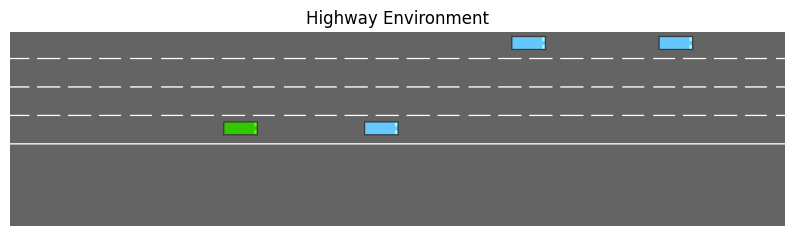

In [12]:
# Visualize initial state
state, _ = env.reset()
plt.figure(figsize=(10, 10))
plt.imshow(env.render())
plt.title("Highway Environment")
plt.axis('off')
plt.show()

## Train the DQN Agent

In [13]:
# Train the DQN agent (use smaller number of episodes for quick test and increase episodes for better performance
agent, rewards = train_dqn(env, episodes=3000, max_steps=200, render=False)
#agent, rewards, losses = train_dqn(env, episodes=3000, max_steps=200, render=False)

Episode 1/3000, Reward: 1.47, Epsilon: 1.00
Episode 2/3000, Reward: 7.14, Epsilon: 1.00
Episode 3/3000, Reward: 8.75, Epsilon: 1.00
Episode 4/3000, Reward: 10.35, Epsilon: 1.00
Episode 5/3000, Reward: 5.56, Epsilon: 1.00
Episode 6/3000, Reward: 3.68, Epsilon: 1.00
Episode 7/3000, Reward: 4.96, Epsilon: 1.00
Episode 8/3000, Reward: 8.63, Epsilon: 1.00
Episode 9/3000, Reward: 4.47, Epsilon: 1.00
Episode 10/3000, Reward: 26.18, Epsilon: 0.99
Episode 11/3000, Reward: 11.63, Epsilon: 0.99
Episode 12/3000, Reward: 3.59, Epsilon: 0.98
Episode 13/3000, Reward: 6.96, Epsilon: 0.98
Episode 14/3000, Reward: 3.83, Epsilon: 0.97
Episode 15/3000, Reward: 4.69, Epsilon: 0.97
Episode 16/3000, Reward: 5.40, Epsilon: 0.96
Episode 17/3000, Reward: 4.69, Epsilon: 0.96
Episode 18/3000, Reward: 12.97, Epsilon: 0.95
Episode 19/3000, Reward: 51.84, Epsilon: 0.95
Episode 20/3000, Reward: 2.15, Epsilon: 0.94
Episode 21/3000, Reward: 46.56, Epsilon: 0.94
Episode 22/3000, Reward: 27.59, Epsilon: 0.94
Episode 23/3

## Plot Training Results

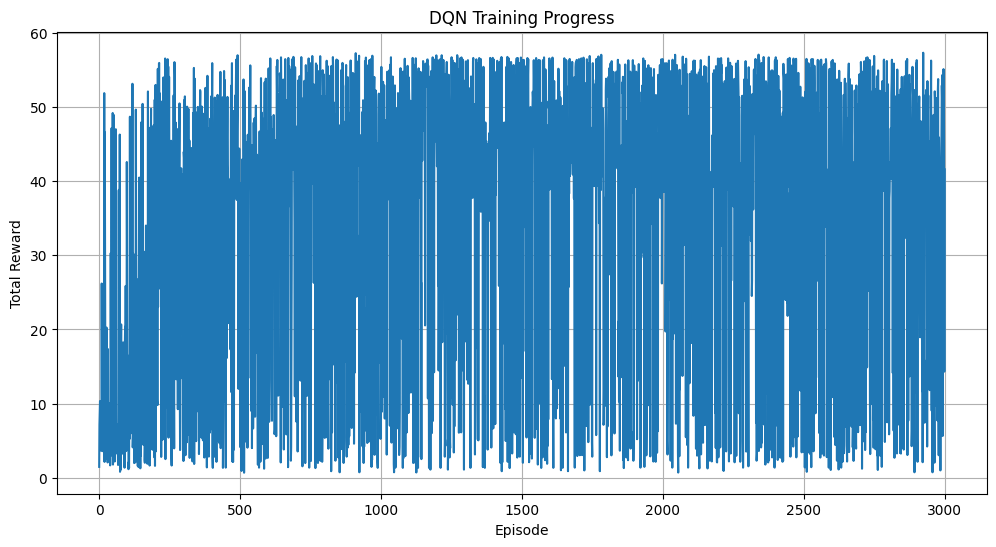

In [17]:
# Plot the training rewards
plt.figure(figsize=(12, 6))
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DQN Training Progress')
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(losses)
plt.xlabel('Episode')
plt.ylabel('Loss Moyenne')
plt.title('Progression de la loss pendant l\'entraînement')
plt.grid(True)
plt.show()

## Visualize Trained Agent

In [11]:
# Visualize trained agent
def live_visualization(agent, env, num_steps=200, delay=0.05):
    state, _ = env.reset()
    import time
    for step in range(num_steps):
        action = agent.get_action(state, epsilon=0)
        state, reward, terminated, truncated, info = env.step(action)
        # This will open a window (or update an existing one) to show the current state
        env.render()
        time.sleep(delay)
        if terminated or truncated:
            print(f"Episode ended after {step+1} steps")
            break

In [ ]:
# Run visualization (this will display multiple frames)
# Set a small number for num_steps to avoid too many outputs
live_visualization(agent, env, num_steps=20)

## Save Trained Model

In [20]:
# To save the trained agent for future use
torch.save(agent.q_net.state_dict(), "dqn_highway_model.pth")
print("Model saved successfully!")

Model saved successfully!


## Load Train Model

In [13]:
# Charger la configuration et créer l'environnement
config_dict = load_config("config.pkl")

# Définir les mêmes hyperparamètres que lors de l'entraînement
gamma = 0.99
batch_size = 64
buffer_capacity = 10000
update_target_every = 100
epsilon_start = 1.0
decrease_epsilon_factor = 200
epsilon_min = 0.05
learning_rate = 1e-3

# Instancier l'agent DQN
agent = DQN(
    env.action_space,
    env.observation_space,
    gamma,
    batch_size,
    buffer_capacity,
    update_target_every,
    epsilon_start,
    decrease_epsilon_factor,
    epsilon_min,
    learning_rate,
)

# Charger le modèle sauvegardé dans l'agent
model_path = "dqn_highway_model.pth"
agent.q_net.load_state_dict(torch.load(model_path))
agent.target_net.load_state_dict(agent.q_net.state_dict())

# Passer en mode évaluation
agent.q_net.eval()
agent.target_net.eval()

print("Le modèle a été chargé avec succès.")

Le modèle a été chargé avec succès.


## Testing Trained model

In [20]:
config_dict = load_config("config.pkl")
env = create_env(config_dict, render_mode='human')

In [23]:
import time

def multi_episode_visualization(agent, env, num_episodes=5, max_steps=200, delay=0.05):
    """
    Visualise l'agent entraîné sur plusieurs épisodes.

    Parameters:
      - agent : l'agent DQN entraîné
      - env : l'environnement Gym configuré de manière cohérente avec l'entraînement
      - num_episodes : nombre d'épisodes à visualiser
      - max_steps : nombre maximum d'étapes par épisode
      - delay : délai entre chaque frame (en secondes)
    """
    for ep in range(num_episodes):
        print(f"--- Episode {ep+1} ---")
        state, _ = env.reset()
        for step in range(max_steps):
            action = agent.get_action(state, epsilon=0)  # mode greedy (pas d'exploration)
            state, reward, terminated, truncated, info = env.step(action)
            env.render()  
            time.sleep(delay)
            if terminated or truncated:
                print(f"Episode {ep+1} terminé après {step+1} steps")
                break
        # Un petit délai entre les épisodes si nécessaire
        time.sleep(1)

# Exemple d'utilisation :
multi_episode_visualization(agent, env, num_episodes=5, max_steps=200, delay=0.05)


--- Episode 1 ---
Episode 1 terminé après 6 steps
--- Episode 2 ---
Episode 2 terminé après 60 steps
--- Episode 3 ---
Episode 3 terminé après 60 steps
--- Episode 4 ---
Episode 4 terminé après 60 steps
--- Episode 5 ---
Episode 5 terminé après 60 steps
